<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab3_TD_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Temporal Difference Learning

In this lab, we will practice TD Learning methods, including SARSA and Q-Learning. Both are tabular methods that work on finite MDP.

We will solve the cliff problem: https://gymnasium.farama.org/environments/toy_text/cliff_walking/#is_slippy


The following code runs in colab, if you want to see the animation, you have to run it using python locally on your computer and replacing render_mode="ansi" for render_mode="human".

Thef follwing code runs the cliff problem using a random policy.

## Exercise 1: SARSA
Implement SARSA to solve the cliff problem above. Recommendations:



1. Define your Q table, as a matrix of [number of states] x [number of actions]
2. Greedy policy: Write a function that receives a state, the Q table, and returns the best action (the one with the maximum Q value).
3. $\epsilon$-greedy: Wreite a function that chooses the greedy policy with $\epsilon$ probality, and chooses a random actions with 1-$\epsilon$ probability.
4. Implement the SARSA algorithm based on the pseudo-code



[Train SARSA] Avg return (last 100): -17.20
[Eval SARSA] Greedy policy average return: -17.00


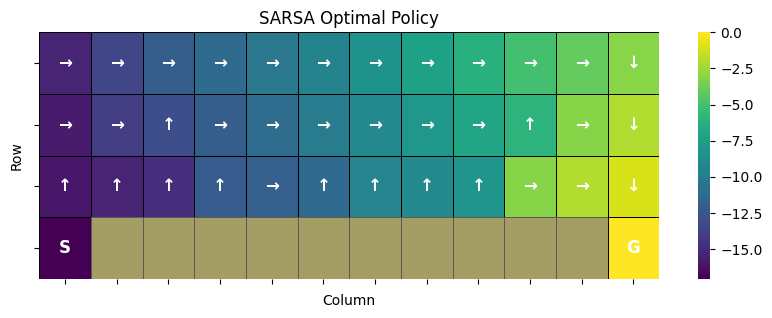

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- 1) setting ----------
env = gym.make("CliffWalking-v1")
nS = env.observation_space.n        # 48 states
nA = env.action_space.n             # 4 actions

def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

rng = np.random.default_rng(seed=0)

def epsilon_greedy_action(Q, s, epsilon):
    if rng.random() < epsilon:
        return int(rng.integers(nA))
    else:
        return greedy_action(Q, s)

def train_sarsa(n_episodes=800, max_steps=100,
                alpha=0.5, gamma=1.0,
                eps_start=0.1, eps_min=0.01, eps_decay=0.995):
    Q = np.zeros((nS, nA), dtype=np.float32)
    epsilon = eps_start
    returns = []

    for ep in range(n_episodes):
        s, _ = env.reset()
        total = 0.0
        a = epsilon_greedy_action(Q, s, epsilon)

        for t in range(max_steps):
            s_next, r, terminated, truncated, _ = env.step(a)
            total += r
            done = bool(terminated) or bool(truncated)

            if not done:
                a_next = epsilon_greedy_action(Q, s_next, epsilon)

            # SARSA: using a_next（If it has ended, no bootstrapping）
            target = r + (0.0 if done else gamma * Q[s_next, a_next])
            Q[s, a] += alpha * (target - Q[s, a])

            if done:
                break
            s, a = s_next, a_next

        # （CliffWalking low boundary：-100 - (max_steps-1)）
        returns.append(float(total))
        # min_return = -100.0 - (max_steps - 1)
        min_return = -100.0 * max_steps
        if (total < min_return - 1e-6) or (total > 0.0 + 1e-6):
            raise RuntimeError(
                f"Episode {ep}: return out of range {total:.2f} "
                f"(expected in [{min_return:.0f}, 0])"
            )

        # ε
        epsilon = max(eps_min, epsilon * eps_decay)

    return Q, returns


# ---------- 4) visualization ----------
def plot_policy(Q, title="Policy (SARSA)"):
    nrow, ncol = 4, 12
    V  = np.max(Q, axis=1).reshape(nrow, ncol)
    PI = np.argmax(Q, axis=1).reshape(nrow, ncol)
    arrow = {0:'↑', 1:'→', 2:'↓', 3:'←'}

    fig, ax = plt.subplots(figsize=(10, 3.2))
    sns.heatmap(V, ax=ax, cmap="viridis", cbar=True,
                linewidths=.6, linecolor="k", annot=False, square=False)
    ax.set_title(title); ax.set_xlabel("Column"); ax.set_ylabel("Row")

    # fall off a cliff
    for c in range(1, ncol-1):
        ax.add_patch(plt.Rectangle((c, nrow-1), 1, 1,
                                   facecolor='0.5', alpha=0.7, zorder=3))

    # 叠加箭头 / S / G
    for r in range(nrow):
        for c in range(ncol):
            if r == nrow-1 and c == 0:
                txt = 'S'
            elif r == nrow-1 and c == ncol-1:
                txt = 'G'
            elif r == nrow-1 and 1 <= c <= ncol-2:
                txt = ''
            else:
                txt = arrow[int(PI[r, c])]
            ax.text(c+0.5, r+0.5, txt, ha='center', va='center',
                    fontsize=12, color='w', weight='bold', zorder=4)

    ax.set_xticklabels([]); ax.set_yticklabels([])
    plt.show()

# ---------- 5) 评估 ----------
def evaluate_policy(Q, episodes=50, max_steps=200):
    tot = 0.0
    for _ in range(episodes):
        s, _ = env.reset()
        ep_ret = 0.0
        for _ in range(max_steps):
            a = greedy_action(Q, s)
            s, r, term, trunc, _ = env.step(a)
            ep_ret += r
            if term or trunc:
                break
        tot += ep_ret
    return tot / episodes

def plot_Q_table(Q, title="SARSA Q-table"):
    nrow, ncol = 4, 12
    G = Q.reshape(nrow, ncol, 4)            # [4,12,4]
    V = np.max(Q, axis=1).reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.heatmap(V, ax=ax, cmap="viridis", cbar=True,
                linewidths=.6, linecolor="k", annot=False, square=False)
    ax.set_title(title); ax.set_xlabel("Column"); ax.set_ylabel("Row")

    # 灰掉悬崖（底行 1..10 列）
    for c in range(1, ncol-1):
        ax.add_patch(plt.Rectangle((c, nrow-1), 1, 1,
                                   facecolor='0.85', alpha=0.9, ec='none'))

    # 在每个格子写 4 个动作值（上、右、下、左）
    for r in range(nrow):
        for c in range(ncol):
            if r == nrow-1 and 1 <= c <= ncol-2:
                continue  # 悬崖格不写
            u, rgt, d, lft = G[r, c]
            ax.text(c+0.50, r+0.22, f"{u:.1f}",  ha='center', va='center', fontsize=8, color='w')  # 上
            ax.text(c+0.78, r+0.50, f"{rgt:.1f}",ha='center', va='center', fontsize=8, color='w')  # 右
            ax.text(c+0.50, r+0.78, f"{d:.1f}",  ha='center', va='center', fontsize=8, color='w')  # 下
            ax.text(c+0.22, r+0.50, f"{lft:.1f}",ha='center', va='center', fontsize=8, color='w')  # 左

    ax.set_xticklabels([]); ax.set_yticklabels([])
    plt.show()

# ---------- 运行 ----------
Q_sarsa, returns_sarsa = train_sarsa()
print(f"[Train SARSA] Avg return (last 100): {np.mean(returns_sarsa[-100:]):.2f}")
print(f"[Eval SARSA] Greedy policy average return: {evaluate_policy(Q_sarsa):.2f}")

plot_policy(Q_sarsa, "SARSA Optimal Policy")


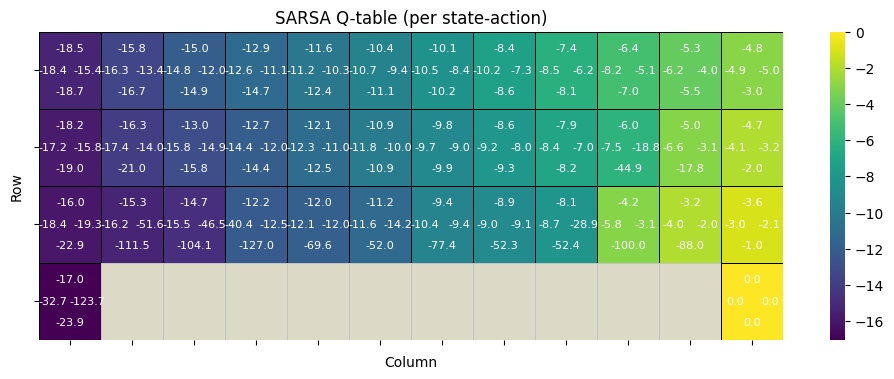

In [ ]:
plot_Q_table(Q_sarsa, "SARSA Q-table (per state-action)")

## Exercise 2.1: Q: Learning
Implement Q-learning method to solve the cliff problem

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make("CliffWalking-v1")
nS = env.observation_space.n  # 48
nA = env.action_space.n       # 4
rng = np.random.default_rng(0)

def greedy_action(Q, s):
    return int(np.argmax(Q[s]))

def epsilon_greedy_action(Q, s, epsilon):
    return int(rng.integers(nA)) if rng.random() < epsilon else greedy_action(Q, s)

def q_to_grid(Q, nrow=4, ncol=12):
    """[48,4] -> [4,12,4]"""
    return Q.reshape(nrow, ncol, 4)

def draw_cliff(ax, nrow=4, ncol=12, color='0.85', alpha=0.9):
    """cliff"""
    for c in range(1, ncol-1):
        ax.add_patch(plt.Rectangle((c, nrow-1), 1, 1, facecolor=color, alpha=alpha, ec='none'))

def plot_policy(Q, title="Policy"):
    nrow, ncol = 4, 12
    V  = np.max(Q, axis=1).reshape(nrow, ncol)
    PI = np.argmax(Q, axis=1).reshape(nrow, ncol)
    arrow = {0:'↑', 1:'→', 2:'↓', 3:'←'}

    fig, ax = plt.subplots(figsize=(10, 3.6))
    sns.heatmap(V, ax=ax, cmap="viridis", cbar=True,
                linewidths=.6, linecolor="k", annot=False, square=False)
    ax.set_title(f"State Value (max_a Q) with Policy Arrows ({title})")
    ax.set_xlabel("Column"); ax.set_ylabel("Row")
    draw_cliff(ax)

    V_mid = np.nanmean(V)
    for r in range(nrow):
        for c in range(ncol):
            if r == nrow-1 and c == 0:         txt = 'S'
            elif r == nrow-1 and c == ncol-1:  txt = 'G'
            elif r == nrow-1 and 1 <= c <= ncol-2: txt = ''
            else:                               txt = arrow[int(PI[r, c])]
            if txt:
                clr = 'w' if V[r, c] <= V_mid else 'k'
                ax.text(c+0.5, r+0.5, txt, ha='center', va='center',
                        fontsize=12, fontweight='bold', color=clr)
    ax.set_xticklabels([]); ax.set_yticklabels([])
    plt.show()

def plot_Q_grid(Q, title="Q-table per cell"):
    nrow, ncol = 4, 12
    G = q_to_grid(Q, nrow, ncol)           # [4,12,4]
    V = np.max(Q, axis=1).reshape(nrow, ncol)

    fig, ax = plt.subplots(figsize=(12, 4))
    sns.heatmap(V, ax=ax, cmap="viridis", cbar=True,
                linewidths=.6, linecolor="k", annot=False, square=False)
    ax.set_title(title); ax.set_xlabel("Column"); ax.set_ylabel("Row")
    draw_cliff(ax)

    for r in range(nrow):
        for c in range(ncol):
            if r == nrow-1 and 1 <= c <= ncol-2:
                continue
            u, rgt, d, lft = G[r, c]
            ax.text(c+0.50, r+0.22, f"{u:.1f}",  ha='center', va='center', fontsize=8, color='w')  # 上
            ax.text(c+0.78, r+0.50, f"{rgt:.1f}",ha='center', va='center', fontsize=8, color='w')  # 右
            ax.text(c+0.50, r+0.78, f"{d:.1f}",  ha='center', va='center', fontsize=8, color='w')  # 下
            ax.text(c+0.22, r+0.50, f"{lft:.1f}",ha='center', va='center', fontsize=8, color='w')  # 左

    ax.set_xticklabels([]); ax.set_yticklabels([])
    plt.show()

def show_Q(Q, decimals=2):
    G = q_to_grid(Q)
    for r in range(G.shape[0]):
        print(f"\nRow {r}:")
        for c in range(G.shape[1]):
            u, rgt, d, lft = G[r, c]
            print(f"({r},{c}) U={u:.{decimals}f} R={rgt:.{decimals}f} D={d:.{decimals}f} L={lft:.{decimals}f}")

def evaluate_policy(Q, episodes=50, max_steps=200):
    tot = 0.0
    for _ in range(episodes):
        s, _ = env.reset()
        ep_ret = 0.0
        for _ in range(max_steps):
            a = greedy_action(Q, s)
            s, r, term, trunc, _ = env.step(a)
            ep_ret += r
            if term or trunc:
                break
        tot += ep_ret
    return tot / episodes

def rollout(Q, max_steps=200):
    path, s = [], env.reset()[0]
    for _ in range(max_steps):
        path.append(s)
        a = greedy_action(Q, s)
        s, r, term, trunc, _ = env.step(a)
        if term or trunc:
            path.append(s); break
    return path


In [ ]:
def train(algo="qlearning", n_episodes=800, max_steps=100,
          alpha=0.5, gamma=1.0, eps_start=0.1, eps_min=0.01, eps_decay=0.995):
    """
    algo: 'qlearning' or 'sarsa'
    return: Q, returns
    """
    Q = np.zeros((nS, nA), dtype=np.float32)
    epsilon = eps_start
    returns = []

    for ep in range(n_episodes):
        s, _ = env.reset()
        total = 0.0

        # SARSA 需要先选一个 a
        if algo == "sarsa":
            a = epsilon_greedy_action(Q, s, epsilon)

        for t in range(max_steps):
            if algo == "qlearning":
                a = epsilon_greedy_action(Q, s, epsilon)

            s_next, r, terminated, truncated, _ = env.step(a)
            total += r

            if algo == "qlearning":
                best_next = 0.0 if (terminated or truncated) else np.max(Q[s_next])
                target = r + gamma * best_next
            else:  # SARSA
                if not (terminated or truncated):
                    a_next = epsilon_greedy_action(Q, s_next, epsilon)
                else:
                    a_next = 0
                target = r + (0 if terminated or truncated else gamma * Q[s_next, a_next])

            Q[s, a] += alpha * (target - Q[s, a])

            if algo == "sarsa":
                s, a = s_next, (a_next if not (terminated or truncated) else a)
            else:
                s = s_next

            if terminated or truncated:
                break

        returns.append(total)
        epsilon = max(eps_min, epsilon * eps_decay)

    return Q, returns

# ====== running：Q-learning ======
Q, returns = train(algo="qlearning", n_episodes=800)
print(f"[Train] Avg return (last 100): {np.mean(returns[-100:]):.2f}")


[Train] Avg return (last 100): -15.42


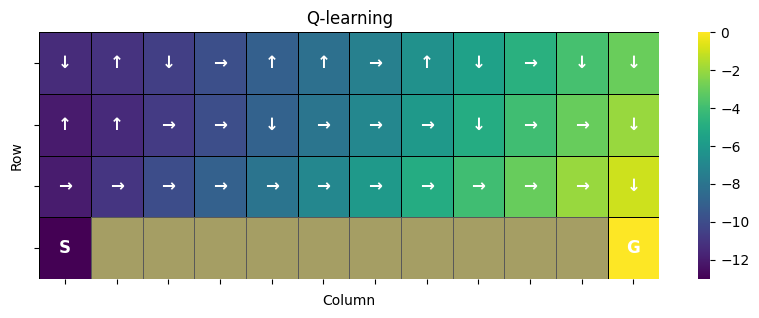

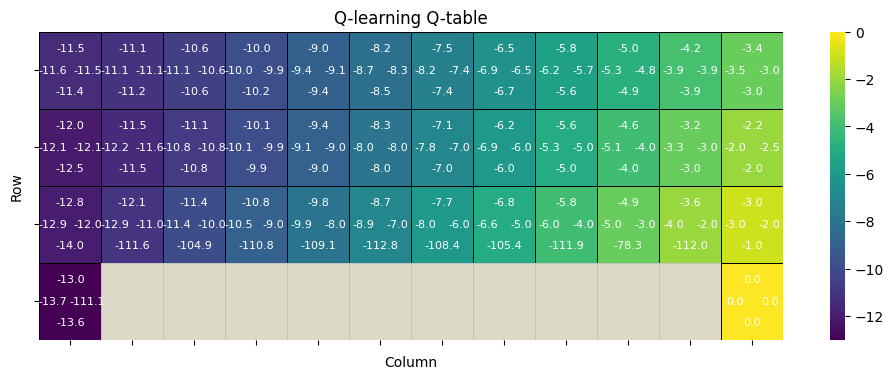

[Eval] Greedy policy average return over 50 episodes: -13.00
Q-learning greedy rollout states: [36, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 47]


In [ ]:
plot_policy(Q, "Q-learning")
plot_Q_grid(Q, "Q-learning Q-table")
print(f"[Eval] Greedy policy average return over 50 episodes: {evaluate_policy(Q):.2f}")
print("Q-learning greedy rollout states:", rollout(Q))
# 可选：终端打印每格四方向的 Q 值
# show_Q(Q, decimals=2)


## Exercise 2.2: SARSA vs Q-learning
 1. Compare the results betwen SARSA and Q-Learning (plot a graph of the sum of rewards duing each episode for each algorithm).
 2. Include the is_slippery=True parameter. Compare again, which one is better?


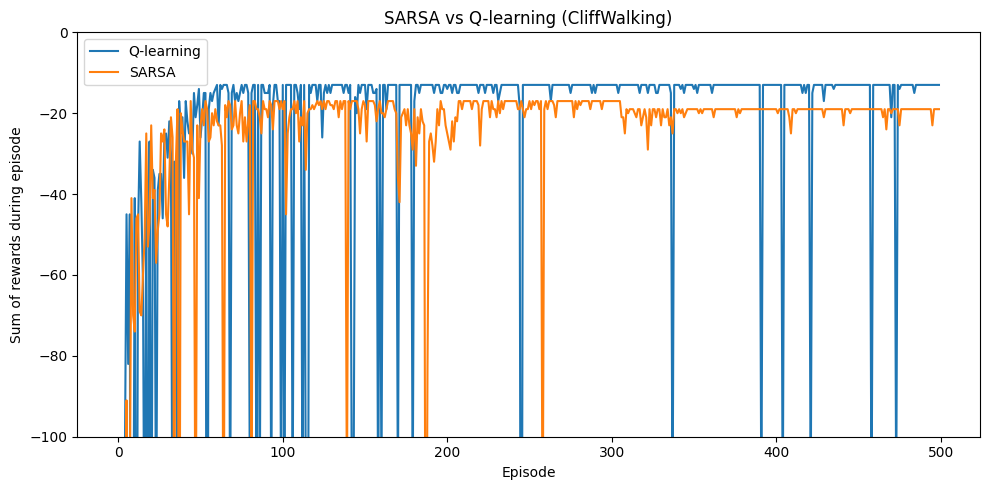

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(returns_q, label="Q-learning")
plt.plot(returns_s, label="SARSA")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards during episode")
plt.title("SARSA vs Q-learning (CliffWalking)")
plt.legend()
plt.ylim(-500, 0)   # 关键：限制 y 轴范围
plt.tight_layout()
plt.show()


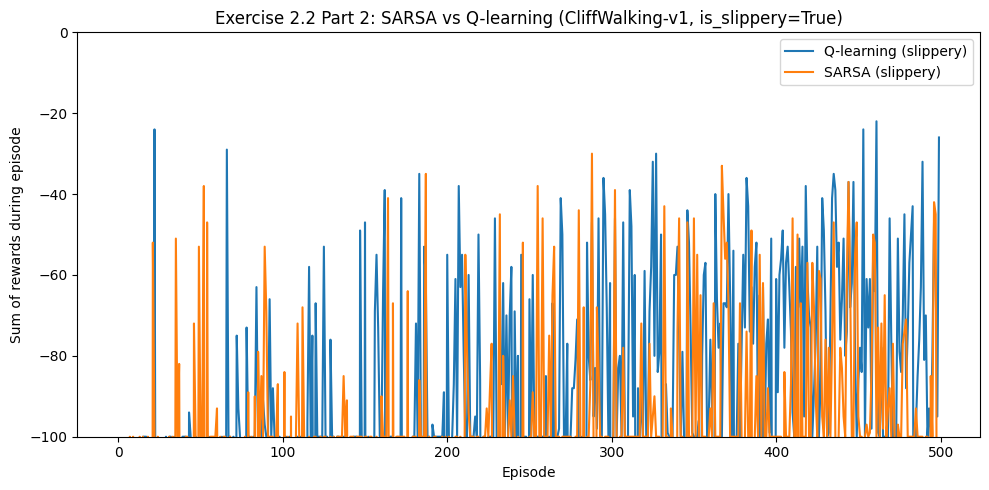

Q-learning avg return (last 100, slippery): -72.27
SARSA avg return (last 100, slippery): -96.76


In [ ]:
# ----- Part 2: SARSA vs Q-learning (is_slippery=True) -----
env = gym.make("CliffWalking-v1", is_slippery=True)

Q_q2, returns_q2 = train(algo="qlearning", n_episodes=500)
Q_s2, returns_s2 = train(algo="sarsa",     n_episodes=500)

plt.figure(figsize=(10,5))
plt.plot(returns_q2, label="Q-learning (slippery)")
plt.plot(returns_s2, label="SARSA (slippery)")
plt.xlabel("Episode")
plt.ylabel("Sum of rewards during episode")
plt.title("Exercise 2.2 Part 2: SARSA vs Q-learning (CliffWalking-v1, is_slippery=True)")
plt.legend()
plt.ylim(-100, 0)   # 限制纵坐标范围
plt.tight_layout()
plt.show()

print(f"Q-learning avg return (last 100, slippery): {np.mean(returns_q2[-100:]):.2f}")
print(f"SARSA avg return (last 100, slippery): {np.mean(returns_s2[-100:]):.2f}")


# Exercise 3 (graduate students): 8x8 grid problem
Solve the 8x8 grid problem from the previous lab. You can use SARSA or Q-learning. How many episodes does it need to learn the optimal policy?


In [2]:
%pip install --upgrade pip
%pip install gymnasium
%pip install gym-simplegrid


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [3]:
import gymnasium as gym
import gym_simplegrid
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# ----- setting -----
ENV_ID = 'SimpleGrid-8x8-v0'
START_LOC = 15
GOAL_LOC  = 3
options = {'start_loc': START_LOC, 'goal_loc': GOAL_LOC}

def shortest_steps(start, goal, n=8):
    rs, cs = divmod(start, n)
    rg, cg = divmod(goal,  n)
    return abs(rs - rg) + abs(cs - cg)

D_STAR = shortest_steps(START_LOC, GOAL_LOC, 8)  # 5

def make_env(render_mode=None):
    return gym.make(ENV_ID, render_mode=render_mode)

def epsilon_greedy(Q, s, eps, nA):
    if np.random.rand() < eps:
        return np.random.randint(nA)
    return np.argmax(Q[s])

def run_episode(env, Q, eps, alpha, gamma, algo='q_learning', max_steps=200):
    """返回: total_reward, steps, success(bool)"""
    obs, info = env.reset(seed=None, options=options)
    nA = env.action_space.n
    s = obs
    a = epsilon_greedy(Q, s, eps, nA) if algo=='sarsa' else None

    total = 0.0
    for t in range(max_steps):
        if algo == 'q_learning':
            a = epsilon_greedy(Q, s, eps, nA)

        ns, r, done, truncated, info = env.step(a)
        total += r

        if algo == 'q_learning':
            td_target = r + gamma * (0.0 if done else np.max(Q[ns]))
            Q[s, a] += alpha * (td_target - Q[s, a])
        else:  # SARSA
            na = epsilon_greedy(Q, ns, eps, nA)
            td_target = r + gamma * (0.0 if done else Q[ns, na])
            Q[s, a] += alpha * (td_target - Q[s, a])
            a = na

        s = ns
        if done:
            return total, t+1, (ns == GOAL_LOC)

    return total, max_steps, False

def evaluate_greedy(env, Q, n_eval=50, max_steps=200):
    nA = env.action_space.n
    succ, steps_list = 0, []
    for _ in range(n_eval):
        s, info = env.reset(options=options)
        for t in range(max_steps):
            a = np.argmax(Q[s])
            s, r, done, truncated, info = env.step(a)
            if done:
                succ += (s == GOAL_LOC)
                steps_list.append(t+1)
                break
        else:
            steps_list.append(max_steps)
    return succ / n_eval, float(np.mean(steps_list))

def learn_optimal(
    algo='q_learning',
    episodes=5000,
    alpha=0.5,
    gamma=0.99,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay=0.995,
    eval_every=20,
    eval_n=50,
    max_steps=200,
    seed=0
):
    np.random.seed(seed)
    env = make_env(render_mode=None)
    nS = env.observation_space.n
    nA = env.action_space.n
    Q = np.zeros((nS, nA), dtype=np.float32)

    eps = eps_start
    returns_ma, steps_ma = [], []
    Rwin, Twin = deque(maxlen=50), deque(maxlen=50)
    converged_at = None

    for ep in range(1, episodes+1):
        G, T, success = run_episode(env, Q, eps, alpha, gamma, algo=algo, max_steps=max_steps)
        Rwin.append(G); Twin.append(T)
        returns_ma.append(np.mean(Rwin))
        steps_ma.append(np.mean(Twin))

        eps = max(eps_end, eps * eps_decay)

        if ep % eval_every == 0:
            succ_rate, mean_steps = evaluate_greedy(env, Q, n_eval=eval_n, max_steps=max_steps)
            print(f"[Eval @ {ep}] success={succ_rate:.2f}, mean_steps={mean_steps:.2f}, eps={eps:.3f}")
            if succ_rate == 1.0 and mean_steps <= D_STAR and converged_at is None:
                converged_at = ep
                print(f"✅ Converged to optimal policy at episode {converged_at} "
                      f"(mean_steps≈{mean_steps:.2f}, shortest={D_STAR})")

    env.close()
    return Q, returns_ma, steps_ma, converged_at

def plot_learning(returns_ma, steps_ma):
    plt.figure(figsize=(8,4))
    plt.plot(returns_ma)
    plt.title("Moving Average of Returns (window=50)")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(steps_ma)
    plt.title("Moving Average of Episode Length (window=50)")
    plt.xlabel("Episode"); plt.ylabel("Steps")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # 选择 'q_learning' 或 'sarsa'
    algo = 'q_learning'
    Q, r_ma, t_ma, converged_at = learn_optimal(
        algo=algo,
        episodes=5000,
        alpha=0.5,
        gamma=0.99,
        eps_start=1.0,
        eps_end=0.05,
        eps_decay=0.995,   # 可调：0.990 更慢、0.998 更稳
        eval_every=20,
        eval_n=50,
        max_steps=200,
        seed=42
    )
    print(f"\nConverged at: {converged_at} (shortest path = {D_STAR} steps)")
    plot_learning(r_ma, t_ma)


[Eval @ 20] success=1.00, mean_steps=5.00, eps=0.905
✅ Converged to optimal policy at episode 20 (mean_steps≈5.00, shortest=5)
[Eval @ 40] success=1.00, mean_steps=5.00, eps=0.818
[Eval @ 60] success=1.00, mean_steps=5.00, eps=0.740
[Eval @ 80] success=1.00, mean_steps=5.00, eps=0.670
[Eval @ 100] success=1.00, mean_steps=5.00, eps=0.606
[Eval @ 120] success=1.00, mean_steps=5.00, eps=0.548
[Eval @ 140] success=1.00, mean_steps=5.00, eps=0.496
[Eval @ 160] success=1.00, mean_steps=5.00, eps=0.448
[Eval @ 180] success=1.00, mean_steps=5.00, eps=0.406
[Eval @ 200] success=1.00, mean_steps=5.00, eps=0.367
[Eval @ 220] success=1.00, mean_steps=5.00, eps=0.332
[Eval @ 240] success=1.00, mean_steps=5.00, eps=0.300
[Eval @ 260] success=1.00, mean_steps=5.00, eps=0.272
[Eval @ 280] success=1.00, mean_steps=5.00, eps=0.246
[Eval @ 300] success=1.00, mean_steps=5.00, eps=0.222
[Eval @ 320] success=1.00, mean_steps=5.00, eps=0.201
[Eval @ 340] success=1.00, mean_steps=5.00, eps=0.182
[Eval @ 360]

SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
